# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 10: *BackProjection*
Compute the position of a region in an image by backrpojection. It uses the
moments of the projections to determine the position of the region in the 
target image
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadRGB, plotImageRGB, createImageF, createImageRGB, plotImageF
from ImagePropertiesUtilities import imageMaxMin
from PlotUtilities import plot3DHistogram
from ImageRegionsUtilities import densityHistogram, colourFeature
                         
# Math and iteration
from math import sqrt
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageNames = Input image name and image containing the new region
    histoSize = Size of the histogram
    positions = Positions of the region in the images [column, row]
    sizeReg = Size of the region
    sigma = Weight control 

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter10/Input/")
imageNames = ["frame1.bmp", "frame2.bmp"]

histoSize = 64
positions = [[100, 60], [89,54]]
sizeReg = [12, 18]
sigma  = 6

### Read image into array

In [3]:
sourceImage, width, height = imageReadRGB(pathToDir + imageNames[0])
targetImage, width, height = imageReadRGB(pathToDir + imageNames[1])

### Show input images

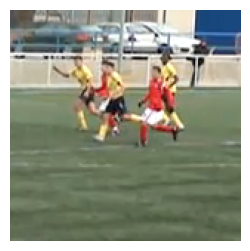

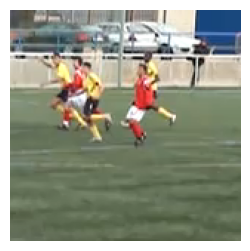

In [4]:
plotImageRGB(sourceImage, figureSize = 3)
plotImageRGB(targetImage, figureSize = 3)

### Density source

In [5]:
q = densityHistogram(sourceImage, positions[0], sizeReg, sigma, histoSize)
#plot3DHistogram(q)

### Projection

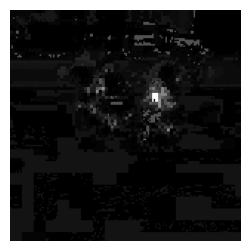

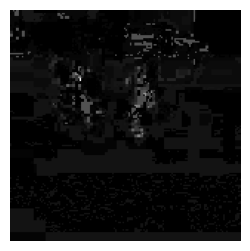

In [6]:
# Projection by setting the pixel's value to the high in the histogram for
#  the source and target images
colourScale = 256.0 / histoSize
projectionSource = createImageF(width, height)
projectionTarget = createImageF(width, height)    
for x, y in itertools.product(range(0,width), range(0, height)):
    
    Cb,Cr = colourFeature(sourceImage[y,x], colourScale)  
    projectionSource[y,x] = q[Cr,Cb]
       
    Cb,Cr = colourFeature(targetImage[y,x], colourScale)    
    projectionTarget[y,x] = q[Cr,Cb]
    
plotImageF(projectionSource, figureSize = 3)
plotImageF(projectionTarget, figureSize = 3)

### Compute geometric moments of the source and target image regions

In [7]:
momS = createImageF(3, 3)
momT = createImageF(3, 3)
ps, pt = positions[0], positions[1]
sizeSearch = [int(sizeReg[0] *1.5), int(sizeReg[1] *1.5)]
for deltaX, deltaY in itertools.product(range(-sizeSearch[0], sizeSearch[0]),   \
                                        range(-sizeSearch[1], sizeSearch[1])):
    xs, ys  = ps[0] + deltaX, ps[1] + deltaY     
    xt, yt  = pt[0] + deltaX, pt[1] + deltaY 
    for m,n in itertools.product(range(0, 3), range(0, 3)):
        momS[n,m] += (xs**n) * (ys**m) * projectionSource[y,x]
        momT[n,m] += (xt**n) * (yt**m) * projectionTarget[y,x]

### Compute sxS, syS, the size of the projection in previous frame

In [8]:
xc,yc = momS[1,0]/momS[0,0], momS[0,1]/momS[0,0]
a = momS[2,0]/momS[0,0] - xc*xc
b = 2*(momS[1,1]/momS[0,0] - xc * yc)
c = momS[0,2]/momS[0,0]- yc*yc;
sxS = int(sqrt((a+c-sqrt(b*b+(a-c)*(a-c))/2)))
syS = int(sqrt((a+c+sqrt(b*b+(a-c)*(a-c))/2)))

### Compute sx, sy, the size of the projection in current frame

In [9]:
xc,yc = momT[1,0]/momT[0,0], momT[0,1]/momT[0,0]
a = momT[2,0]/momT[0,0] - xc*xc
b = 2*(momT[1,1]/momT[0,0] - xc * yc)
c = momT[0,2]/momT[0,0]- yc*yc;
sx = int(sqrt((a+c-sqrt(b*b+(a-c)*(a-c))/2)))
sy = int(sqrt((a+c+sqrt(b*b+(a-c)*(a-c))/2)))

### Determine size of the region in current frame

In [10]:
sy = int(sy * sizeReg[1] /  syS)
sx = int(sx * sizeReg[0] /  sxS)

### Show results

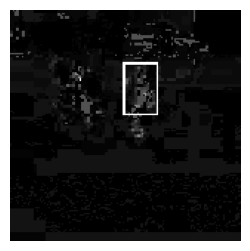

In [12]:
p = [int(xc), int(yc)]
m, _ = imageMaxMin(projectionTarget)
borderDistance = [sx -2, sy -2]
for x, y in itertools.product(range(p[0] - sx, p[0] + sx),                 \
                              range(p[1] - sy, p[1] + sy)):
        
    if abs(x-p[0]) > borderDistance[0] or abs(y-p[1]) > borderDistance[1]:
        projectionTarget[y,x] = m
  
plotImageF(projectionTarget, figureSize = 3)